              price      bedrooms      latitude     longitude     area_sqft  \
count  5.405600e+04  49253.000000  54056.000000  54056.000000  53974.000000   
mean   2.518156e+06      1.321097     25.187606     55.273028   1092.879182   
std    7.232277e+06      0.960806      0.005361      0.010178    882.418612   
min    1.000000e+05      0.000000     25.176570     55.252289     87.190000   
25%    1.093750e+06      1.000000     25.184163     55.266352    620.000000   
50%    1.620230e+06      1.000000     25.186458     55.271720    883.070000   
75%    2.528916e+06      2.000000     25.191831     55.281155   1335.050000   
max    6.501300e+08      7.000000     25.201816     55.293192  20979.160000   

           plot_sqft  
count      82.000000  
mean    71562.953537  
std    110814.436207  
min      4837.190000  
25%     34439.015000  
50%     47825.300000  
75%     61021.170000  
max    675087.590000  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54056 entries, 0 to 54055
Data 

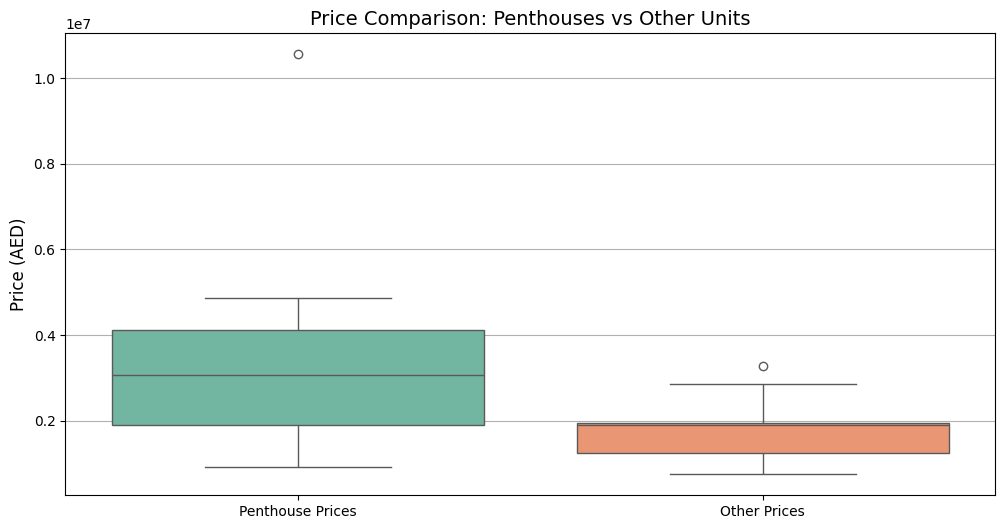

P-value for the effect of penthouses on unit prices: 0.033235848562509406


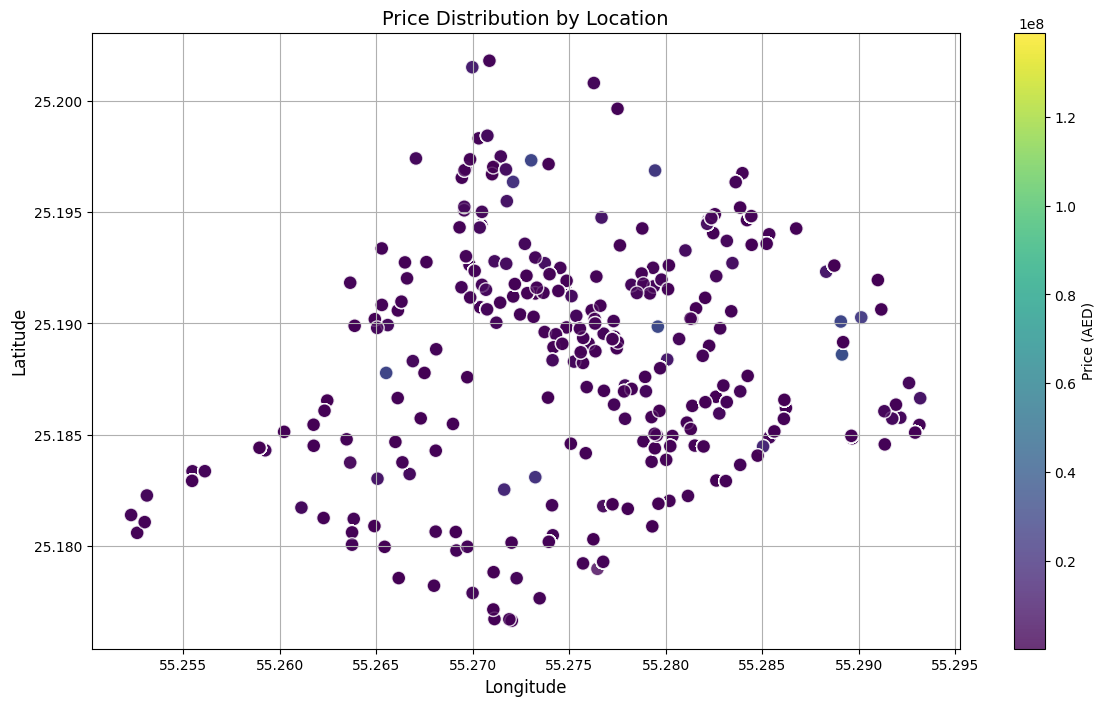

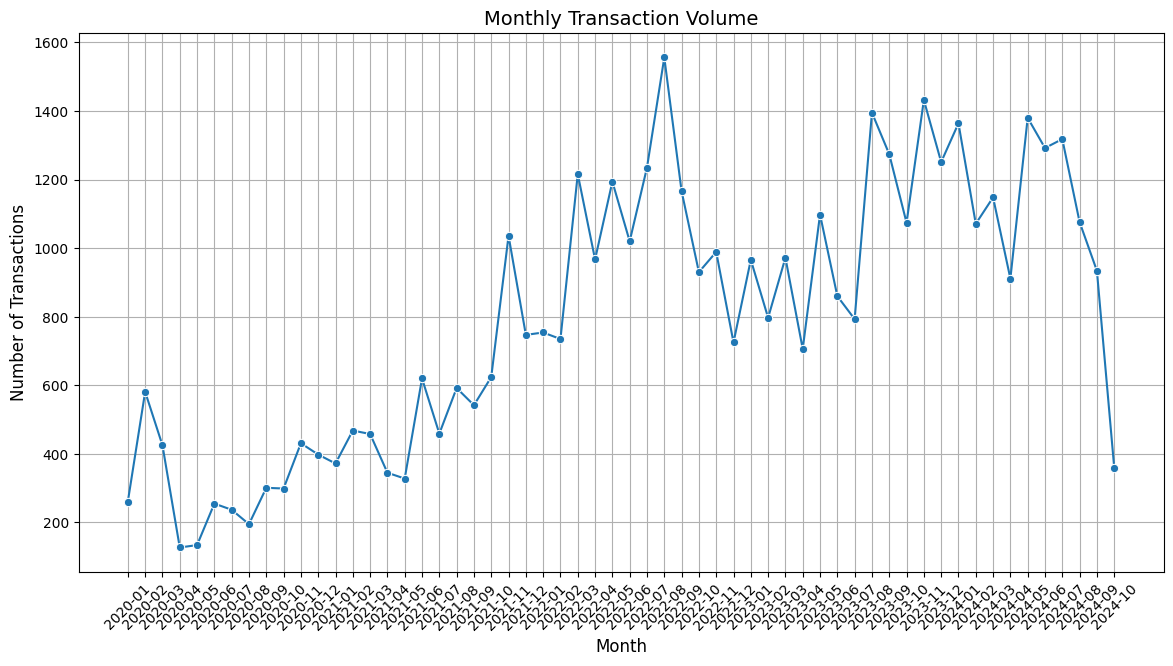

C:\Users\DELL\AppData\Local\Temp\ipykernel_2572\1591682615.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='mixed_use', y='price', data=data, palette="pastel")


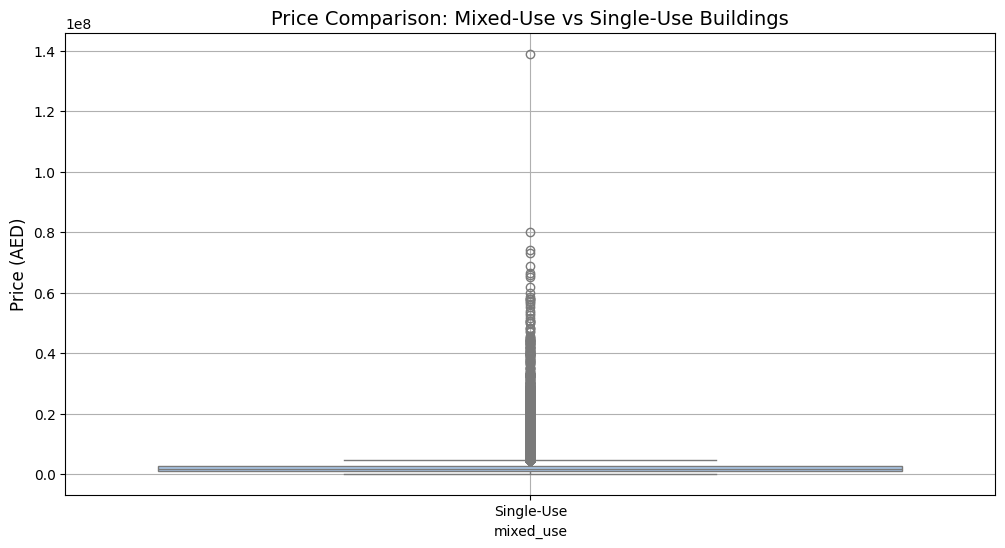

Mean Squared Error: 1064225881174.05
R² Score: 0.8856729066695677
F1 Score: 0.9619238476953907


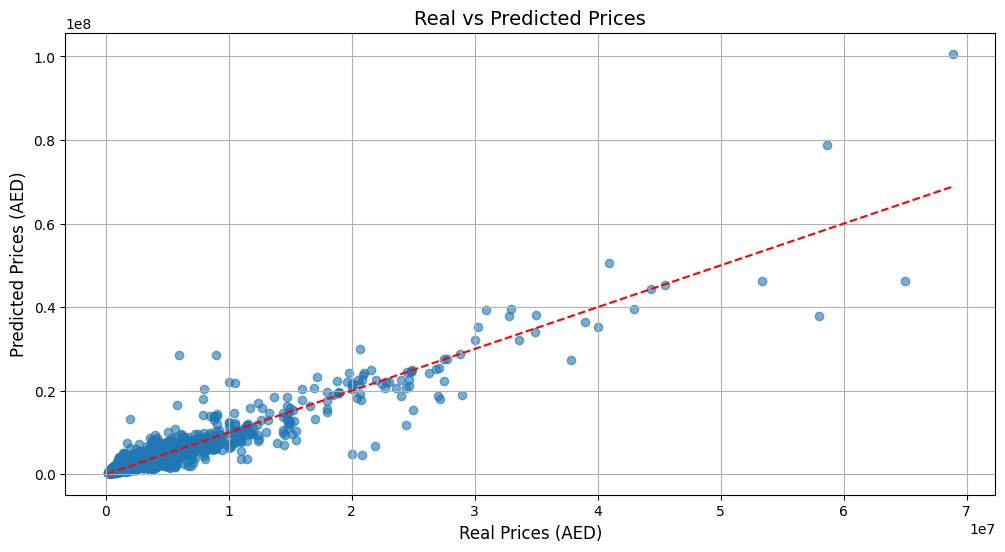

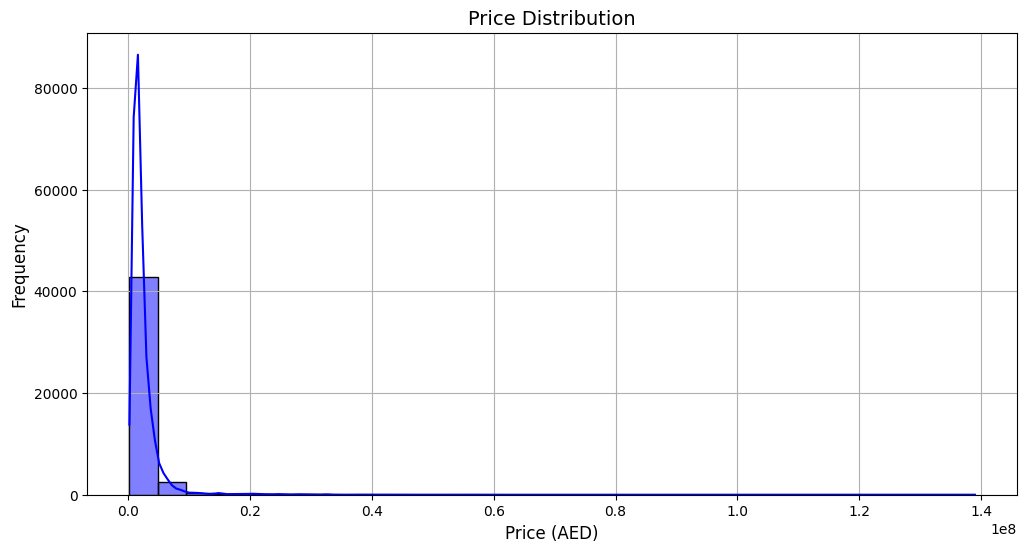

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


try:
    data = pd.read_csv('Transactions.csv')
except Exception as e:
    print(f"Error loading data: {e}")


print(data.describe())
print(data.info())


data = data.dropna(subset=['price', 'bedrooms', 'area_sqft', 'floor', 'latitude', 'longitude'])

# اطمینان از اینکه قیمت‌ها و سایر ستون‌های عددی به نوع عددی تبدیل شده‌اند
data['price'] = pd.to_numeric(data['price'], errors='coerce')
data['bedrooms'] = pd.to_numeric(data['bedrooms'], errors='coerce')
data['area_sqft'] = pd.to_numeric(data['area_sqft'], errors='coerce')
data['floor'] = pd.to_numeric(data['floor'], errors='coerce')

# 1. تحلیل اثر پنت‌هاوس‌ها بر قیمت‌ها
def analyze_penthouses(data):
    penthouse_data = data[data['property_type'] == 'Penthouse']
    other_units = data[data['property_type'] != 'Penthouse']

    penthouse_avg_price = penthouse_data.groupby('address')['price'].mean().reset_index()
    other_avg_price = other_units.groupby('address')['price'].mean().reset_index()

    merged_data = pd.merge(penthouse_avg_price, other_avg_price, on='address', suffixes=('_penthouse', '_other'))

    t_stat, p_value = stats.ttest_ind(merged_data['price_penthouse'].dropna(), merged_data['price_other'].dropna())

    plt.figure(figsize=(12, 6))
    sns.boxplot(data=[merged_data['price_penthouse'].dropna(), merged_data['price_other'].dropna()], palette="Set2")
    plt.xticks([0, 1], ['Penthouse Prices', 'Other Prices'])
    plt.ylabel('Price (AED)', fontsize=12)
    plt.title('Price Comparison: Penthouses vs Other Units', fontsize=14)
    plt.grid(axis='y')
    plt.show()

    return p_value

# 2. تأثیر مکان بر قیمت‌ها
def analyze_location(data):
    plt.figure(figsize=(14, 8))
    scatter = plt.scatter(data['longitude'], data['latitude'], c=data['price'], cmap='viridis', alpha=0.8, edgecolors='w', s=100)
    plt.colorbar(scatter, label='Price (AED)')
    plt.title('Price Distribution by Location', fontsize=14)
    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12)
    plt.grid()
    plt.show()

# 3. شناسایی نقاط داغ
def detect_hotspots(data):
    data['date'] = pd.to_datetime(data['date'], errors='coerce')
    data['month'] = data['date'].dt.to_period('M')
    data = data.dropna(subset=['month'])

    monthly_sales = data.groupby('month')['price'].count().reset_index()
    monthly_sales['month'] = monthly_sales['month'].astype(str)

    plt.figure(figsize=(14, 7))
    sns.lineplot(data=monthly_sales, x='month', y='price', marker='o')
    plt.title('Monthly Transaction Volume', fontsize=14)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Number of Transactions', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

# 4. اثر ساختمان‌های چندمنظوره بر قیمت‌ها
def analyze_mixed_use(data):
    data['mixed_use'] = data['property_usage'].apply(lambda x: 'Mixed-Use' if 'Commercial' in x else 'Single-Use')

    plt.figure(figsize=(12, 6))
    sns.boxplot(x='mixed_use', y='price', data=data, palette="pastel")
    plt.title('Price Comparison: Mixed-Use vs Single-Use Buildings', fontsize=14)
    plt.ylabel('Price (AED)', fontsize=12)
    plt.grid()
    plt.show()

# 5. پیش‌بینی قیمت ملک با استفاده از جنگل تصادفی
def predict_price(data):
    X = data[['bedrooms', 'area_sqft', 'floor', 'latitude', 'longitude']]
    y = data['price']

    imputer = SimpleImputer(strategy='mean')
    X = imputer.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Grid Search 
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
    }
    
    grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=3, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'Mean Squared Error: {mse}')
    print(f'R² Score: {r2}')

    return y_test, y_pred  

# 6. پیش‌بینی قیمت با استفاده از طبقه‌بندی
def predict_price_classification(data):
    data['high_price'] = (data['price'] > 1000000).astype(int)

    X = data[['bedrooms', 'area_sqft', 'floor', 'latitude', 'longitude']]
    y = data['high_price']

    imputer = SimpleImputer(strategy='mean')
    X = imputer.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestClassifier(n_estimators=100)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    f1 = f1_score(y_test, y_pred)
    print(f'F1 Score: {f1}')

# 7. توزیع قیمت‌ها
def plot_price_distribution(data):
    plt.figure(figsize=(12, 6))
    sns.histplot(data['price'], bins=30, kde=True, color='blue')
    plt.title('Price Distribution', fontsize=14)
    plt.xlabel('Price (AED)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid()
    plt.show()

# 8. مقایسه قیمت‌های واقعی و پیش‌بینی شده
def plot_real_vs_predicted(y_test, y_pred):
    plt.figure(figsize=(12, 6))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # خط یکنواخت
    plt.title('Real vs Predicted Prices', fontsize=14)
    plt.xlabel('Real Prices (AED)', fontsize=12)
    plt.ylabel('Predicted Prices (AED)', fontsize=12)
    plt.grid()
    plt.show()


p_value_penthouses = analyze_penthouses(data)
print(f"P-value for the effect of penthouses on unit prices: {p_value_penthouses}")

analyze_location(data)
detect_hotspots(data)
analyze_mixed_use(data)
y_test, y_pred = predict_price(data)  
predict_price_classification(data)
plot_real_vs_predicted(y_test, y_pred)  
plot_price_distribution(data)  